In [1]:
import numpy as np
import pandas as pd
import os
import re
import glob
from skbio.alignment import local_pairwise_align, TabularMSA
from skbio import Protein
import itertools 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [2]:
def read_fasta(fp):
    name, seq = None, []
    for line in fp:
        line = line.rstrip()
        if line.startswith(">"):
            if name: yield (name, ''.join(seq))
            name, seq = line, []
        else:
            seq.append(line)
    if name: yield (name, ''.join(seq))

def get_sequences(dir):
    files = glob.glob(dir + '/*.fa')
    sequences = []
    for filepath in glob.iglob(os.path.join(dir, "*.fa")):
        with open(filepath) as fp:
            for name, seq in read_fasta(fp):
                sequences.append(seq)
    print("Read in %d fasta files"%len(files))
    return sequences

def read_score_matrix(filename):
    '''
    Read score matrices as dataframe.
    Input: score matrix 
    Output: dataframe
    '''
    with open(filename) as mat:
        matrix = mat.read()
        lines = matrix.strip().split('\n')
        score_matrix = []
        for line in lines:
            if not line.startswith("#"):
                score_matrix.append(line)
    aas_column = pd.DataFrame(score_matrix[0].strip().split("  "))
    scores = []
    for i in range(len(score_matrix)-1):
        ls = score_matrix[i+1].strip()
        new = ls.split(" ")
        sub = []
        for n in new:
            if n != "":
                sub.append(int(n))
        scores.append(sub)
        score_df = pd.DataFrame(scores)
        score_df.columns = score_matrix[0].strip().split("  ")
    df_score = aas_column.join(score_df)
    df_score = df_score.set_index([0])
    return df_score

In [3]:
def get_negpair_seq(dir):
    '''
    Get sequences for negative pairs.
    Input: Directory for all the sequences
    Output: List of negative pairs sequences
    '''
    files = glob.glob(dir + '/*.fa')
    negpair_list = open('/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/Negpairs.txt').read().splitlines()
    neg_files, neg_files2 = [],[]
    negpair_sequences, negpair2_sequences  = [], []
    for seq_file in files:
        for negpair in negpair_list:
            if negpair[10:22] in seq_file[-12:]:
                neg_files.append(seq_file)
            if negpair[33:] in seq_file[-12:]:
                neg_files2.append(seq_file)
    for neg_file in neg_files:
        with open(neg_file) as neg:
            for name, neg_seq in read_fasta(neg):
                negpair_sequences.append(neg_seq)
    for neg_file in neg_files2:
        with open(neg_file) as neg:
            for name, neg2_seq in read_fasta(neg):
                negpair2_sequences.append(neg2_seq)
    #Some of the sequences has "x" as a gap. I'm replacing those 'x's with '-'
    #so it works with skbio package. Not really a good way but it works.
    without_x = [s for s in negpair2_sequences if 'x' not in s]
    with_x= [s for s in negpair2_sequences if 'x' in s]
    with_x =' '.join(with_x)
    with_x = with_x.replace('x', '-')
    without_x.append(with_x)
    negpair2_sequences = without_x
    print("Read in %d negative pair fasta files" %len(negpair_sequences))
    print("Read in %d negative pair fasta files" %len(negpair2_sequences))
    return negpair_sequences, negpair2_sequences

def get_pospair_seq(dir):
    '''
    Get sequences for positive pairs.
    Input: Directory for all the sequences
    Output: List of positive pairs sequences
    '''
    files = glob.glob(dir + '/*.fa')
    pospair_list = open('/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/Pospairs.txt').read().splitlines()
    pos_files,pos2_files = [],[]
    pospair_sequences,pospair2_sequences = [],[]
    for seq_file in files:
        for pospair in pospair_list:
            if pospair[10:22] in seq_file[-12:]:
                pos_files.append(seq_file)
            if pospair[33:] in seq_file[-12:]:
                pos2_files.append(seq_file)
    for pos_file in pos_files:
        with open(pos_file) as pos:
            for name, pos_seq in read_fasta(pos):
                pospair_sequences.append(pos_seq)
    for pos_file in pos2_files:
        with open(pos_file) as pos:
            for name, pos2_seq in read_fasta(pos):
                pospair2_sequences.append(pos2_seq)    
    print("Read in %d positive pair fasta files" %len(pospair_sequences))
    print("Read in %d positive pair fasta files" %len(pospair2_sequences))
    return pospair_sequences, pospair2_sequences

In [4]:
def read_score_matrix(filepath):
    with open(filepath) as mat:
        matrix = mat.read()
        lines = matrix.strip().split('\n')
        score_matrix = []
        for line in lines:
            if not line.startswith("#"):
                score_matrix.append(line)
    aas_column = pd.DataFrame(score_matrix[0].strip().split("  "))
    scores = []
    for i in range(len(score_matrix)-1):
        ls = score_matrix[i+1].strip()
        new = ls.split(" ")
        sub = []
        for n in new:
            if n != "":
                sub.append(int(n))
        scores.append(sub)
        score_df = pd.DataFrame(scores)
        score_df.columns = score_matrix[0].strip().split("  ")
    df_score = aas_column.join(score_df)
    df_score = df_score.set_index([0])
    return df_score
   

                    

In [5]:
def align(seq1, seq2, gap_open_penalty, gap_extend_penalty, substitution_matrix):
    sequence1 = Protein(seq1)
    sequence2 = Protein(seq2)
    return local_pairwise_align(sequence1, sequence2, gap_open_penalty, gap_extend_penalty, substitution_matrix)
    

In [142]:
directory = '/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/sequences/'
negpairs1, negpairs2 = get_negpair_seq(directory)
pospairs1, pospairs2 = get_pospair_seq(directory)
blosum50 = read_score_matrix('/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/matrices/BLOSUM50')
blosum62 = read_score_matrix('/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/matrices/BLOSUM62')
matio = read_score_matrix('/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/matrices/MATIO')
pam100 = read_score_matrix('/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/matrices/PAM100')
pam250 = read_score_matrix('/Users/Snow/Desktop/BMI203_Algorithm/HW3_SNaing_2018/matrices/PAM250')


Read in 50 negative pair fasta files
Read in 50 negative pair fasta files
Read in 50 positive pair fasta files
Read in 50 positive pair fasta files


# Finding best gap panalties scores at TPR = 0.7 for BLOSUM50

In [66]:
possible_gap_extend_penalties = list(range(1,6))
possible_gap_open_penalties = list(range(1,21))
best_fpr = float('inf')
best_gap = None
best_extension = None

for open_penalty in possible_gap_open_penalties: 
    for extend_penalty in possible_gap_extend_penalties:
        pos_align_score = []
        neg_align_score = []
        for i in range(0,len(pospairs1)):
            aln_p, score_p, _ = align(pospairs1[i],pospairs2[i], open_penalty,extend_penalty, blosum50)
            aln_n, score_n, _ = align(negpairs1[i],negpairs2[i], open_penalty,extend_penalty, blosum50)
            pos_align_score.append(score_p)
            neg_align_score.append(score_n)
        pos_align_score.sort()
        neg_align_score.sort()
        tpr = 0.7 #tpr = #>thresh / total scores
        cutoff_index = int((1-tpr)*len(pos_align_score))# find the index that makes it so tpr*lenscores is > threshold
        threshold = pos_align_score[cutoff_index]
        neg_score_np = np.array(neg_align_score)
        fpr = len(neg_score_np[neg_score_np > threshold])/len(neg_score_np) #False Positive Rate
        if fpr < best_fpr:
            best_fpr = fpr
            best_gap = open_penalty
            best_extension = extend_penalty
    
print('Best Open and extension gap penalty scores are %d and %d.' % (best_gap,best_extension))
print('Best False positive rate is %d.' %(best_fpr))
            
            

Best Open and extension gap penalty scores are 1 and 5.
Best False positive rate is 0.


# Finding best scoring matrix; Plotting ROC graph

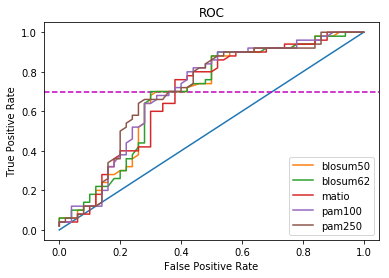

In [108]:
matrices = [blosum50,blosum62,matio,pam100,pam250]
matrix_names = ['blosum50','blosum62','matio','pam100','pam250']
score_list = [] #Combined negative and positive scores as numpy array
true_pos = [1]*50 # ture_pos = [1]*len(pos)
true_neg = [0]*50 # ture_neg = [0]*len(neg)
combined_trues = np.concatenate((true_pos,true_neg)) #Telling sckit-roc curve which are pos, which are neg

for m in matrices: 
    pos_align_score =[]
    neg_align_score = []
    for i in range(0,len(pospairs1)):
        aln_p, score_p, _ = align(pospairs1[i],pospairs2[i], best_gap ,best_extension, m)
        aln_n, score_n, _ = align(negpairs1[i],negpairs2[i], best_gap ,best_extension, m)
        pos_align_score.append(score_p)
        neg_align_score.append(score_n)    
    score_list.append(np.concatenate((np.asarray(pos_align_score), np.asarray(neg_align_score))))

plt.figure()
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.axhline(0.7, color = 'm', linestyle = '--')
for score, label in zip(score_list, matrix_names):
    fpr,tpr, treshold = roc_curve(combined_trues,score, pos_label=1)
    plt.plot(fpr, tpr, label=label)
plt.legend()
plt.show()
plt.close()

# Normalize SW score with shortest sequence length

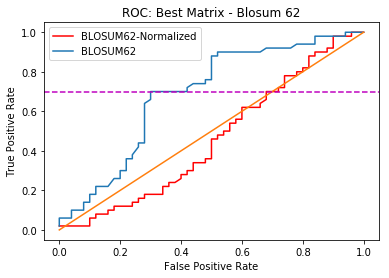

In [107]:
norm_pos_score, norm_neg_score = [], []
for i in range(0,len(pospairs1)):
    aln_p, score_p, _ = align(pospairs1[i],pospairs2[i], best_gap ,best_extension, blosum62)
    aln_n, score_n, _ = align(negpairs1[i],negpairs2[i], best_gap ,best_extension, blosum62)
    norm_pos = score_p/min(len(pospairs1[i]),len(pospairs2[i]))
    norm_neg = score_n/min(len(negpairs1[i]),len(negpairs2[i]))
    norm_pos_score.append(norm_pos)
    norm_neg_score.append(norm_neg)

norm_pos_np = np.asarray(norm_pos_score)
norm_neg_np = np.asarray(norm_neg_score)
norm_combined = np.concatenate((norm_pos_np,norm_neg_np))
norm_true_pos = [1]*len(norm_pos_score)
norm_true_neg = [0]*len(norm_neg_score)
norm_combined_trues = np.concatenate((norm_true_pos,norm_true_neg))

norm_fpr,norm_tpr, treshold = roc_curve(norm_combined_trues,norm_combined, pos_label=1) #This is for normalized ROC
fpr,tpr, treshold = roc_curve(combined_trues,score_list[1], pos_label=1) # This is for regular ROC
plt.figure()
plt.plot(norm_fpr,norm_tpr, 'r', label = 'BLOSUM62-Normalized')
plt.plot(fpr, tpr, label = 'BLOSUM62')
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC: Best Matrix - Blosum 62")
plt.axhline(0.7, color = 'm', linestyle = '--')
plt.show()
plt.close()

# Optimization

In [60]:
def obj_fun(pos, neg):
    '''
    return sum of TP rates for FP rates of 0.0, 0.1, 0.2, and 0.3.
    '''

    fp = []
    tp = []

    for t in [0.0,0.1,0.2,0.3]:
        thresh = np.percentile(neg, 100*(1-t))
        false_positives = [i for i in neg if i > thresh]
        fpr = len(false_positives)/float(len(neg))
        true_positives = [i for i in pos if i > thresh]
        tpr = len(true_positives)/float(len(pos))
        tp.append(tpr)
        fp.append(fpr)

    return(sum(tp))

In [100]:
def new_matrix(matrices):
    '''
    Randomoly switches indices of original scoring matrix. (i.e. giving amino acids new scores.)
    Return 5 new matrices. 
    '''
    new_matrices = []
    for m in matrices: 
        new_mat = m.copy()
        a,b,c,d,e,f = np.random.choice(range(len(m.columns)), 6)
        index = list(m.columns)
        index[a], index[b], index[c], index[d], index[e], index[f]= index[f], index[e], index[a], index[b], index[c], index[d]
        new_mat.columns = index
        new_mat.index = index
        new_matrices.append(new_mat)
    return new_matrices 

In [ ]:
new_matrix_names= ['blosum50-mut','blosum62-mut','matio-mut','pam100-mut','pam250-mut']
new_score_list = [] #Combined negative and positive scores as numpy array
new_true_pos= [1]*50 # ture_pos = [1]*len(pos)
new_true_neg= [0]*50 # ture_neg = [0]*len(neg)
new_combined_trues= np.concatenate((new_true_pos,new_true_neg)) #Telling sckit-roc curve which are pos, which are neg
obj_sum_tps= [] #For calculating sum of tps using objective function
max_fitness = 0 # To calculate max fitness
for m in new_matrix(matrices): 
    new_pos_align_score =[]
    new_neg_align_score = []
    print ('At matrix!')
    for i in range(0,len(pospairs1)):
        aln_p, new_score_p, _ = align(pospairs1[i],pospairs2[i], best_gap ,best_extension, m)
        aln_n, new_score_n, _ = align(negpairs1[i],negpairs2[i], best_gap ,best_extension, m)
        new_pos_align_score.append(new_score_p)
        new_neg_align_score.append(new_score_n)
        print('At score!')
        sum_tps = obj_fun(new_pos_align_score, new_neg_align_score)
        obj_sum_tps.append(sum_tps)
        if sum_tps > max_fitness:
            max_fitness = sum_tps
            print ('calculated Max Fitness!')
    new_score_list.append(np.concatenate((np.asarray(new_pos_align_score), np.asarray(new_neg_align_score))))

plt.figure()
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC using new mutated score matrices")
plt.axhline(0.7, color = 'y', linestyle = '--')
for new_score, new_label in zip(new_score_list, new_matrix_names):
    new_fpr,new_tpr, treshold = roc_curve(new_combined_trues,new_score, pos_label=1)
    plt.plot(new_fpr, new_tpr, label=new_label)
plt.legend()
plt.show()
plt.close()

In [124]:
new_mat = new_matrix(matrices)

In [134]:
blosum50_mut = pd.DataFrame(new_mat[0])
blosum62_mut = pd.DataFrame(new_mat[1])
matio_mut = pd.DataFrame(new_mat[2])
pam100_mut = pd.DataFrame(new_mat[3])
pam250_mut = pd.DataFrame(new_mat[4])

In [136]:
blosum50_mut.to_csv('blosum50-mut.txt', index=True, sep=' ', header=True)
blosum62_mut.to_csv('blosum62-mut.txt', index=True, sep=' ', header=True)
matio_mut.to_csv('matio_mut.txt', index=True, sep=' ', header=True)
pam100_mut.to_csv('pam100-mut.txt', index=True, sep=' ', header=True)
pam250_mut.to_csv('pam250-mut.txt', index=True, sep=' ', header=True)